# Flight Data — Time Series Analysis & Seasonal Decomposition

This notebook performs **comprehensive time series analysis** on flight operations data, uncovering temporal patterns, seasonal trends, and day-of-week effects.

## Analysis Overview

This analysis aims to understand how flight operations vary over time by examining:

1. **Overall Flight Activity Trends** - Are flights increasing or decreasing?
2. **Seasonal Patterns** - Do patterns repeat weekly or monthly?
3. **Day-of-Week Effects** - How does operational performance vary by weekday?
4. **Operational Efficiency** - How do metrics like delays and air time behave?

## Key Metrics

- **Flight Count**: Total daily flights
- **Cancellation Rate**: Proportion of cancelled flights per day
- **Delay Intensity**: Average total delay (weather + late aircraft) per flight
- **Operational Efficiency**: Air time per 1000 miles (minutes)
- **Seasonal Strength**: How strong the weekly pattern is (0-1 scale)

---

In [ ]:
# Setup and Configuration
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")

# Kaggle-ready: Auto-detect data location
def find_data_file(preferred='../input/flight-data/flight_data_2024.csv', local='../input'):
    """Auto-detect Kaggle or local data file."""
    if os.path.exists('/kaggle/input'):
        matches = glob.glob('/kaggle/input/**/flight_data_2024.csv', recursive=True)
        if matches:
            return matches[0]
    
    # Try preferred path
    if os.path.exists(preferred):
        return preferred
    
    # Try common local paths
    for path in ['data/flight_data_2024.csv', '../input/flight_data_2024.csv', 'flight_data_2024.csv']:
        if os.path.exists(path):
            return path
    
    return preferred

# Configuration
OUTPUT_DIR = 'outputs'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Visualization settings
sns.set(style="whitegrid", context="talk", palette="husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Setup complete. Ready to analyze flight data.")

✓ Setup complete. Ready to analyze flight data.


## 1. Data Loading & Preparation

We load the flight data and prepare it for time series analysis by aggregating daily metrics.

In [23]:
def load_flight_data(file_path=None):
    # Auto-detect data location
    data_file = None
    
    # Try Kaggle environment first
    if os.path.exists('/kaggle/input'):
        matches = glob.glob('/kaggle/input/**/flight_data_2024.csv', recursive=True)
        if matches:
            data_file = matches[0]
    
    # Try local paths (relative to notebook location)
    if data_file is None:
        local_paths = [
            '../data/flight_data_2024.csv',  # One level up from notebooks/
            'data/flight_data_2024.csv',     # From project root
        ]
        for path in local_paths:
            if os.path.exists(path):
                data_file = path
                break
    
    if data_file is None:
        raise FileNotFoundError(
            'Could not find flight_data_2024.csv in:\n'
            '  - /kaggle/input/ (Kaggle environment)\n'
            '  - ../data/ (local directory, relative to notebook)\n'
            '  - data/ (project root)\n\n'
            'Solution: Place the CSV file in the "data/" folder in your project root'
        )
    
    print(f"Loading data from: {data_file}")
    df = pd.read_csv(data_file)
    print(f"✓ Loaded {len(df):,} rows × {len(df.columns)} columns")
    
    # Process date column
    if 'fl_date' in df.columns:
        df['fl_date'] = pd.to_datetime(df['fl_date'], errors='coerce')
        
        # Add temporal features
        if 'month' not in df.columns:
            df['month'] = df['fl_date'].dt.month
        if 'day_of_week' not in df.columns:
            df['day_of_week'] = df['fl_date'].dt.dayofweek + 1
    
    # Create readable day names
    dow_map = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
    if 'day_of_week' in df.columns:
        df['day_name'] = df['day_of_week'].map(dow_map).fillna('Unknown')
    
    print(f"✓ Date range: {df['fl_date'].min().date()} to {df['fl_date'].max().date()}")
    return df

# Load data
raw_df = load_flight_data()
print(f"\nData sample:\n{raw_df.head()}")

Loading data from: ../data/flight_data_2024.csv
✓ Loaded 1,048,575 rows × 18 columns
✓ Loaded 1,048,575 rows × 18 columns
✓ Date range: 2024-01-01 to 2024-02-29

Data sample:
   year  month  day_of_month  day_of_week    fl_date origin origin_city_name  \
0  2024      1             1            1 2024-01-01    JFK     New York, NY   
1  2024      1             1            1 2024-01-01    MSP  Minneapolis, MN   
2  2024      1             1            1 2024-01-01    JFK     New York, NY   
3  2024      1             1            1 2024-01-01    RIC     Richmond, VA   
4  2024      1             1            1 2024-01-01    DTW      Detroit, MI   

  origin_state_nm  dep_time  taxi_out  wheels_off  wheels_on  taxi_in  \
0        New York    1247.0      31.0      1318.0     1442.0      7.0   
1       Minnesota    1001.0      20.0      1021.0     1249.0      6.0   
2        New York    1411.0      21.0      1432.0     1533.0      8.0   
3        Virginia    1643.0      13.0      1656.0   

In [ ]:
def prepare_time_series_data(df):
    """
    Aggregate flight metrics by date to create daily time series.
    
    Args:
        df (pd.DataFrame): Raw flight data
        
    Returns:
        pd.DataFrame: Daily aggregated metrics with temporal features
    """
    ts_df = df.copy()
    
    # Aggregate by date
    daily_flights = ts_df.groupby('fl_date').agg({
        'origin': 'count',                             # Flight count
        'cancelled': ['sum', 'mean'],                  # Cancellation metrics
        'dep_time': 'count',                           # Departed flights
        'air_time': ['mean', 'std'],                   # Air time variability
        'distance': ['mean', 'sum'],                   # Distance metrics
        'weather_delay': ['sum', 'mean'],              # Weather delays
        'late_aircraft_delay': ['sum', 'mean'],        # Late aircraft delays
        'taxi_out': 'mean',                            # Taxi out time
        'taxi_in': 'mean'                              # Taxi in time
    }).round(2)
    
    # Flatten multi-level column names
    daily_flights.columns = [
        'flight_count', 'cancellations_total', 'cancellation_rate',
        'departed_flights', 'avg_air_time', 'air_time_std',
        'avg_distance', 'total_distance', 'weather_delay_total',
        'avg_weather_delay', 'late_delay_total', 'avg_late_delay',
        'avg_taxi_out', 'avg_taxi_in'
    ]
    
    # Derived metrics
    daily_flights['operational_efficiency'] = (
        daily_flights['avg_air_time'] / daily_flights['avg_distance'] * 1000
    ).round(3)  # minutes per 1000 miles
    
    daily_flights['delay_intensity'] = (
        daily_flights['weather_delay_total'] + daily_flights['late_delay_total']
    ) / daily_flights['flight_count']  # average total delay per flight
    
    # Temporal features
    daily_flights['day_of_week'] = daily_flights.index.dayofweek
    daily_flights['day_name'] = daily_flights.index.day_name()
    daily_flights['is_weekend'] = daily_flights['day_of_week'].isin([5, 6])
    
    return daily_flights

# Prepare time series data
ts_data = prepare_time_series_data(raw_df)
print(f"✓ Time series prepared: {len(ts_data)} days")
print(f"\nDaily metrics sample:\n{ts_data.head()}")
print(f"\nSummary statistics:\n{ts_data.describe().round(2)}")

✓ Time series prepared: 60 days

Daily metrics sample:
            flight_count  cancellations_total  cancellation_rate  \
fl_date                                                            
2024-01-01         17265                   18                0.0   
2024-01-02         18977                   25                0.0   
2024-01-03         18520                   19                0.0   
2024-01-04         18066                   65                0.0   
2024-01-05         18109                   17                0.0   

            departed_flights  avg_air_time  air_time_std  avg_distance  \
fl_date                                                                  
2024-01-01             17250        118.23         71.28        866.15   
2024-01-02             18954        118.32         70.49        861.29   
2024-01-03             18501        118.14         70.85        857.36   
2024-01-04             18005        117.94         70.89        857.34   
2024-01-05             1

## 2. Seasonal Decomposition Analysis

Seasonal decomposition separates a time series into four components:

1. **Observed** - The actual data
2. **Trend** - Long-term direction (increasing/decreasing)
3. **Seasonal** - Repeating patterns (weekly cycles)
4. **Residual** - Irregular variations and anomalies


SEASONAL DECOMPOSITION: FLIGHT COUNT (Weekly Period=7)
Flight Count Insights:
   • Seasonal Strength: 0.164 (0=no pattern, 1=strong pattern)
   • Trend Direction: Increasing
   • Trend Start Value: 18422.8
   • Trend End Value: 18466.9


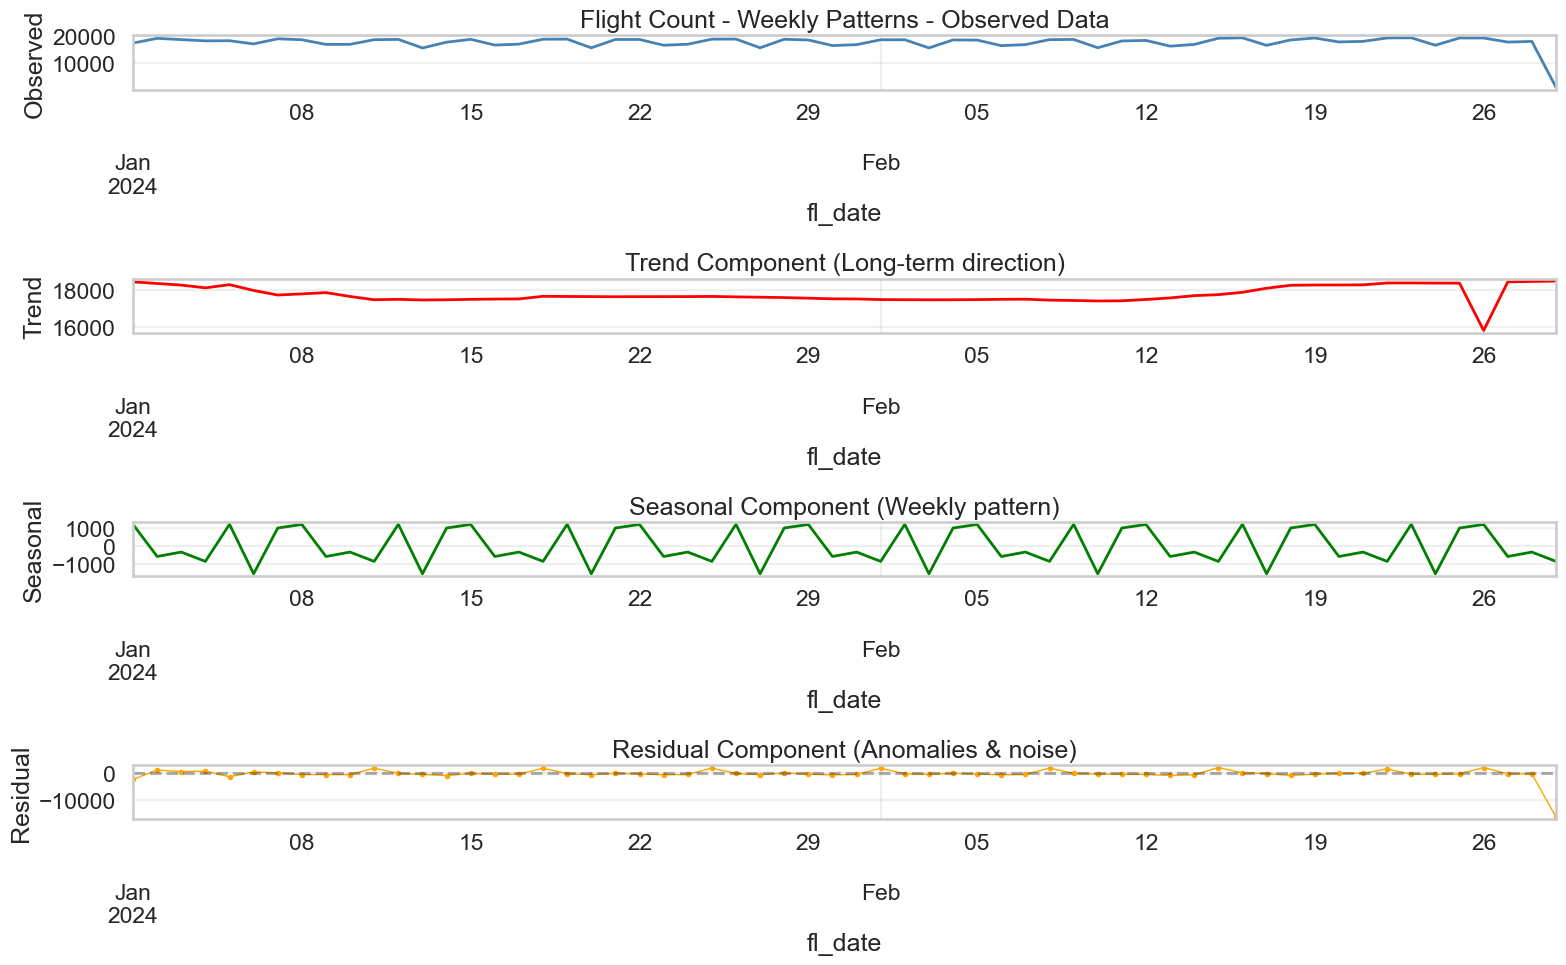


✓ Chart saved: 01_flight_count_decomposition.png


In [26]:

def seasonal_decomposition_analysis(ts_data, column, model='additive', period=7):
    if len(ts_data) < 2 * period:
        print(f"⚠ Warning: Only {len(ts_data)} data points. Adjusting period from {period} to {len(ts_data)//2}")
        period = len(ts_data) // 2
    
    # Fill missing values
    series = ts_data[column].fillna(method='ffill').fillna(method='bfill')
    
    # Perform decomposition
    decomposition = seasonal_decompose(
        series, 
        model=model, 
        period=period,
        extrapolate_trend='freq'
    )
    
    return decomposition

def plot_decomposition(decomposition, title="Seasonal Decomposition", figsize=(16, 10)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    
    # Original series
    decomposition.observed.plot(ax=axes[0], color='steelblue', linewidth=2)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(f'{title} - Observed Data')
    axes[0].grid(True, alpha=0.3)
    
    # Trend component
    decomposition.trend.plot(ax=axes[1], color='red', linewidth=2)
    axes[1].set_ylabel('Trend')
    axes[1].set_title('Trend Component (Long-term direction)')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal component
    decomposition.seasonal.plot(ax=axes[2], color='green', linewidth=2)
    axes[2].set_ylabel('Seasonal')
    axes[2].set_title('Seasonal Component (Weekly pattern)')
    axes[2].grid(True, alpha=0.3)
    
    # Residual component
    decomposition.resid.plot(ax=axes[3], color='orange', linewidth=1, marker='o', markersize=3)
    axes[3].set_ylabel('Residual')
    axes[3].set_title('Residual Component (Anomalies & noise)')
    axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Analyze Flight Count with weekly patterns
print("\n" + "="*70)
print("SEASONAL DECOMPOSITION: FLIGHT COUNT (Weekly Period=7)")
print("="*70)

fc_decomp = seasonal_decomposition_analysis(ts_data, 'flight_count', period=7)

# Calculate insights
seasonal_strength = 1 - (fc_decomp.resid.var() / (fc_decomp.seasonal + fc_decomp.resid).var())
trend_direction = 'Increasing' if fc_decomp.trend.dropna().iloc[-1] > fc_decomp.trend.dropna().iloc[0] else 'Decreasing'

print(f"Flight Count Insights:")
print(f"   • Seasonal Strength: {seasonal_strength:.3f} (0=no pattern, 1=strong pattern)")
print(f"   • Trend Direction: {trend_direction}")
print(f"   • Trend Start Value: {fc_decomp.trend.dropna().iloc[0]:.1f}")
print(f"   • Trend End Value: {fc_decomp.trend.dropna().iloc[-1]:.1f}")

# Plot
fig1 = plot_decomposition(fc_decomp, title='Flight Count - Weekly Patterns')
plt.savefig(f'{OUTPUT_DIR}/01_flight_count_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: 01_flight_count_decomposition.png")

### Chart Explanation: Flight Count Decomposition

**What it shows:**
- **Observed**: Raw daily flight counts showing natural variability
- **Trend**: The underlying long-term direction - whether flights are generally increasing or decreasing
- **Seasonal**: The regular weekly pattern that repeats - peaks on busy days, valleys on quiet days
- **Residual**: Irregular variations that don't fit the pattern - these are anomalies worth investigating

**How to interpret:**
- **Strong seasonal pattern** (strength > 0.5) means weekdays behave very differently from weekends
- **Positive trend** indicates growing flight volume; **negative trend** indicates declining volume
- **Large residuals** on specific dates indicate unusual operational days (weather events, holidays, etc.)


SEASONAL DECOMPOSITION: CANCELLATION RATE (Weekly Period=7)
Cancellation Rate Insights:
   • Seasonal Strength: 0.259
   • Trend Direction: Increasing
   • Average Cancellation Rate: 0.0215 (2.15%)
   • Highest Day: Tuesday
   • Lowest Day: Thursday


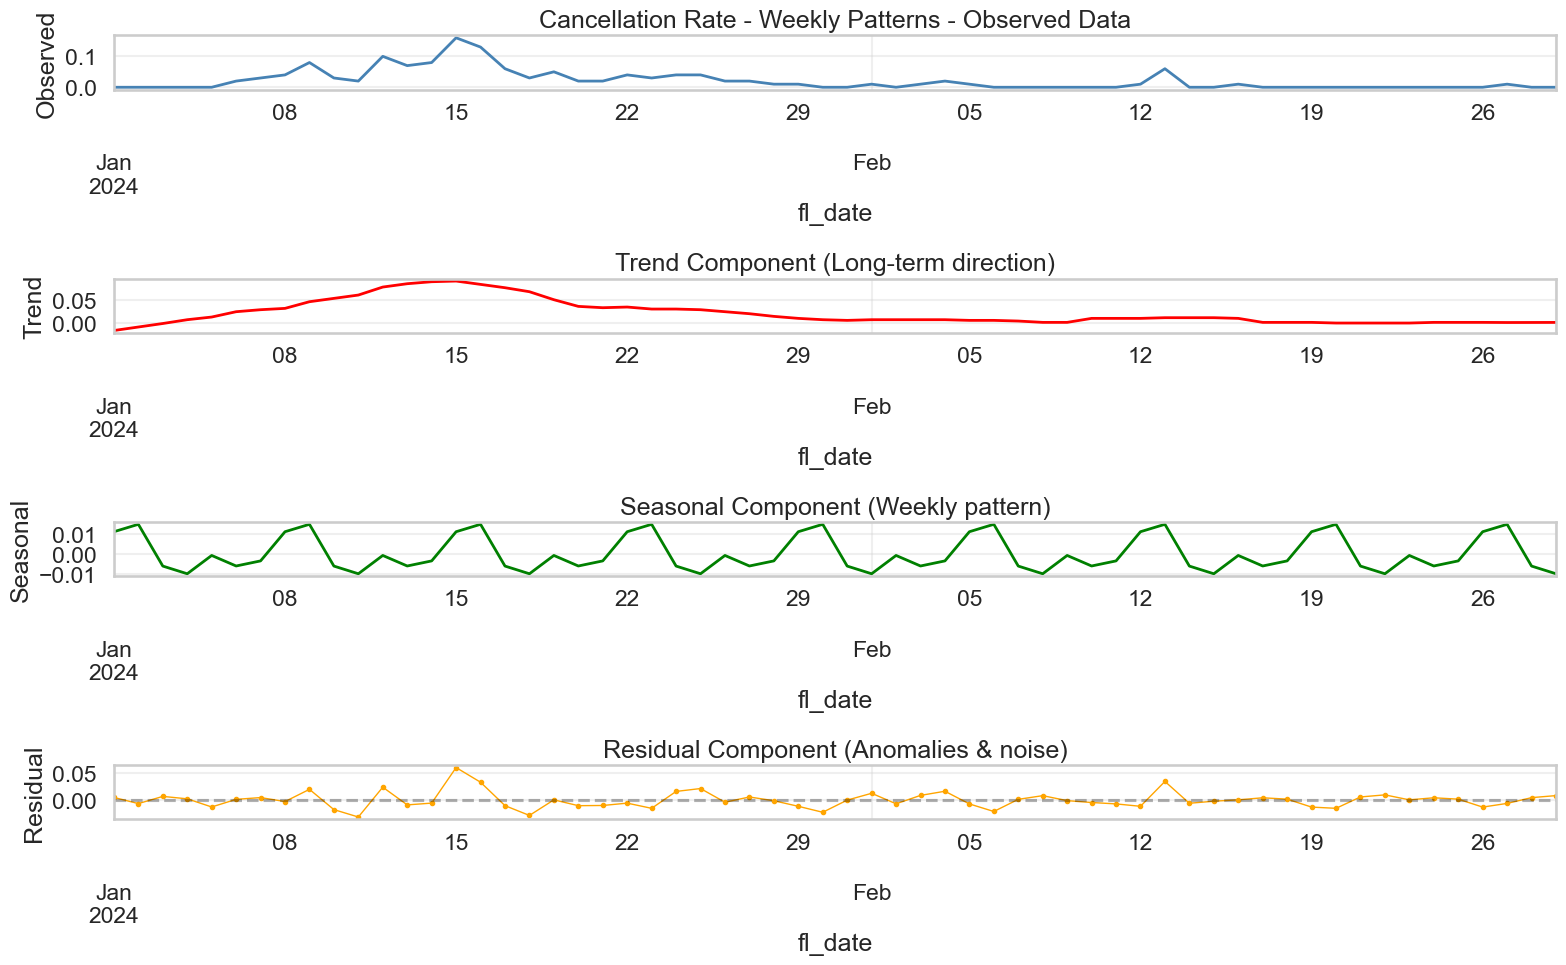


✓ Chart saved: 02_cancellation_rate_decomposition.png


In [28]:

# Analyze Cancellation Rate
print("\n" + "="*70)
print("SEASONAL DECOMPOSITION: CANCELLATION RATE (Weekly Period=7)")
print("="*70)

cancel_decomp = seasonal_decomposition_analysis(ts_data, 'cancellation_rate', period=7)

seasonal_strength_cancel = 1 - (cancel_decomp.resid.var() / (cancel_decomp.seasonal + cancel_decomp.resid).var())
trend_direction_cancel = 'Increasing' if cancel_decomp.trend.dropna().iloc[-1] > cancel_decomp.trend.dropna().iloc[0] else 'Decreasing'

print(f"Cancellation Rate Insights:")
print(f"   • Seasonal Strength: {seasonal_strength_cancel:.3f}")
print(f"   • Trend Direction: {trend_direction_cancel}")
print(f"   • Average Cancellation Rate: {ts_data['cancellation_rate'].mean():.4f} ({ts_data['cancellation_rate'].mean()*100:.2f}%)")
print(f"   • Highest Day: {ts_data.groupby('day_name')['cancellation_rate'].mean().idxmax()}")
print(f"   • Lowest Day: {ts_data.groupby('day_name')['cancellation_rate'].mean().idxmin()}")

fig2 = plot_decomposition(cancel_decomp, title='Cancellation Rate - Weekly Patterns')
plt.savefig(f'{OUTPUT_DIR}/02_cancellation_rate_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: 02_cancellation_rate_decomposition.png")

### Chart Explanation: Cancellation Rate Decomposition

**What it shows:**
- **Observed**: Daily cancellation rate (fraction of flights cancelled per day)
- **Trend**: Whether cancellations are generally worsening or improving over time
- **Seasonal**: Which days of the week have systematically higher/lower cancellation rates
- **Residual**: Unexpected cancellation spikes - these might correlate with weather events or operational issues

**Key Insights:**
- **Strong weekly seasonality** indicates specific days are more reliable (e.g., weekdays vs weekends)
- **Increasing trend** signals operational challenges that need attention
- **Large residuals** on certain dates warrant investigation - they often correlate with severe weather or system failures


SEASONAL DECOMPOSITION: AVERAGE AIR TIME (Weekly Period=7)
Air Time Insights:
   • Seasonal Strength: 0.356
   • Average Air Time: 116.0 minutes
   • Min Air Time: 102.3 minutes
   • Max Air Time: 121.3 minutes
   • Std Dev: 2.6 minutes (operational variability)


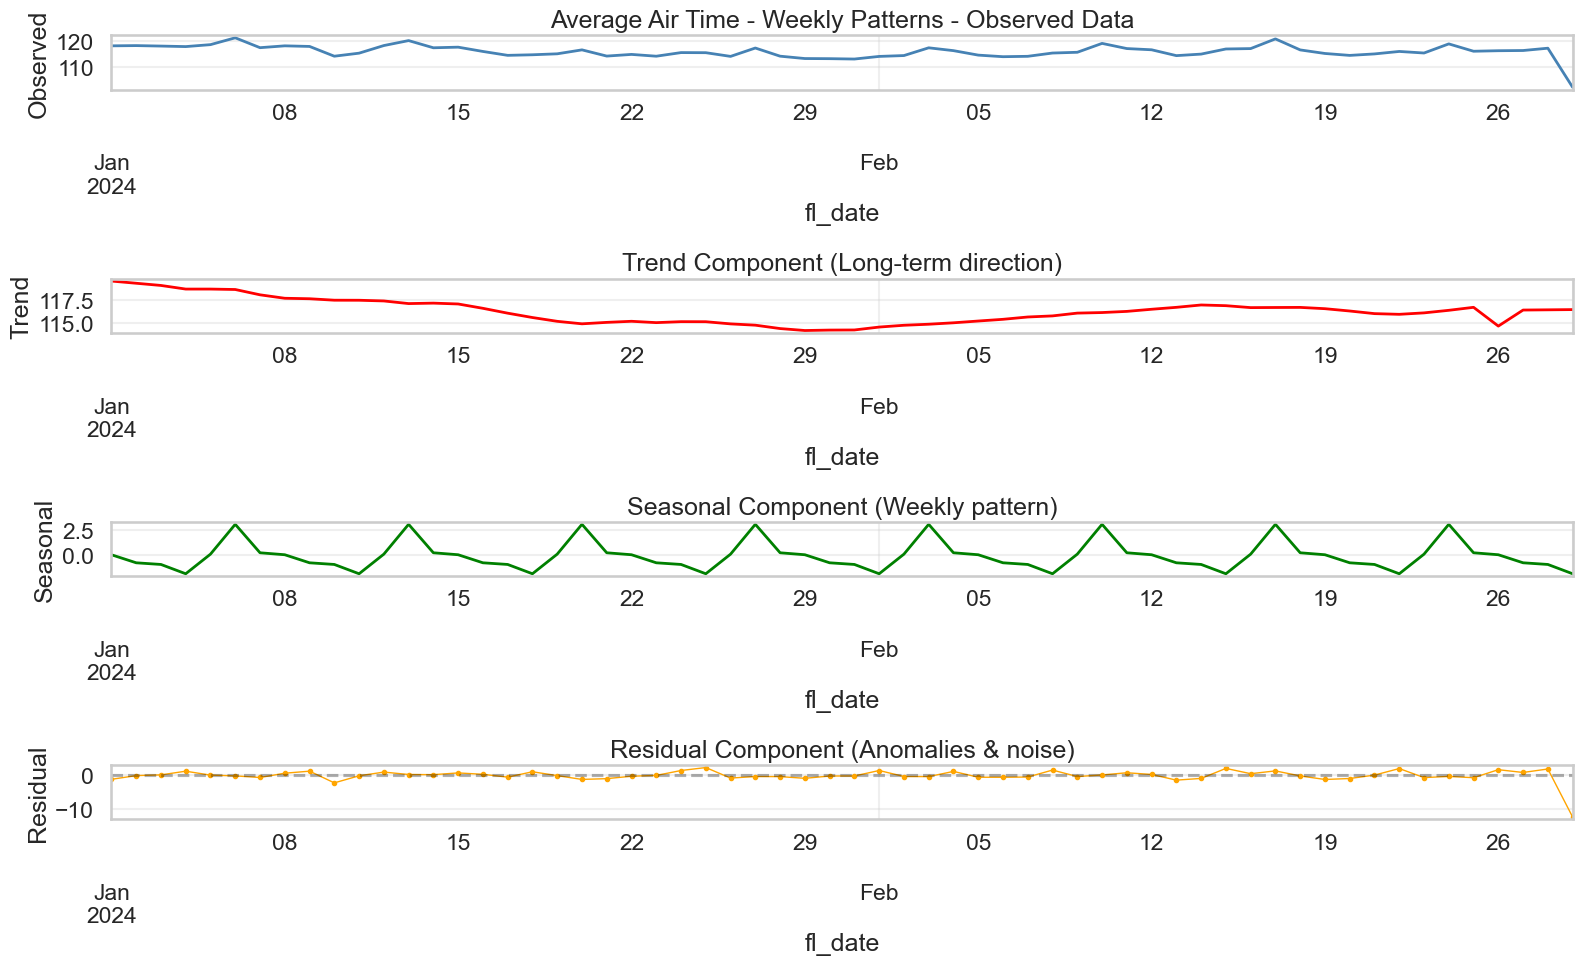


✓ Chart saved: 03_air_time_decomposition.png


In [29]:

# Analyze Air Time (operational efficiency)
print("\n" + "="*70)
print("SEASONAL DECOMPOSITION: AVERAGE AIR TIME (Weekly Period=7)")
print("="*70)

airtime_decomp = seasonal_decomposition_analysis(ts_data, 'avg_air_time', period=7)

seasonal_strength_air = 1 - (airtime_decomp.resid.var() / (airtime_decomp.seasonal + airtime_decomp.resid).var())

print(f"Air Time Insights:")
print(f"   • Seasonal Strength: {seasonal_strength_air:.3f}")
print(f"   • Average Air Time: {ts_data['avg_air_time'].mean():.1f} minutes")
print(f"   • Min Air Time: {ts_data['avg_air_time'].min():.1f} minutes")
print(f"   • Max Air Time: {ts_data['avg_air_time'].max():.1f} minutes")
print(f"   • Std Dev: {ts_data['avg_air_time'].std():.1f} minutes (operational variability)")

fig3 = plot_decomposition(airtime_decomp, title='Average Air Time - Weekly Patterns')
plt.savefig(f'{OUTPUT_DIR}/03_air_time_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: 03_air_time_decomposition.png")

### Chart Explanation: Air Time Decomposition

**What it shows:**
- **Observed**: Daily average air time (minutes from wheels-off to wheels-on)
- **Trend**: Whether flights are getting faster or slower - can indicate route changes or fleet changes
- **Seasonal**: Which days have different average flight times (heavier aircraft on certain routes on certain days?)
- **Residual**: Unusual flight times that deviate from the pattern (strong headwinds, route diversions, etc.)

**Key Insights:**
- **Increasing trend** = flights taking longer (could mean longer routes, more congestion, or older aircraft)
- **Decreasing trend** = flights taking less time (could mean more direct routes, newer aircraft, or favorable winds)
- **Weekly pattern** = certain days might use different equipment or flight routes (e.g., weekend leisure flights vs weekday business routes)


SEASONAL DECOMPOSITION: DELAY INTENSITY (Weekly Period=7)
Delay Intensity Insights:
   • Seasonal Strength: 0.162
   • Average Delay per Flight: 6.56 minutes
   • Min Delay per Flight: 1.68 minutes
   • Max Delay per Flight: 26.76 minutes


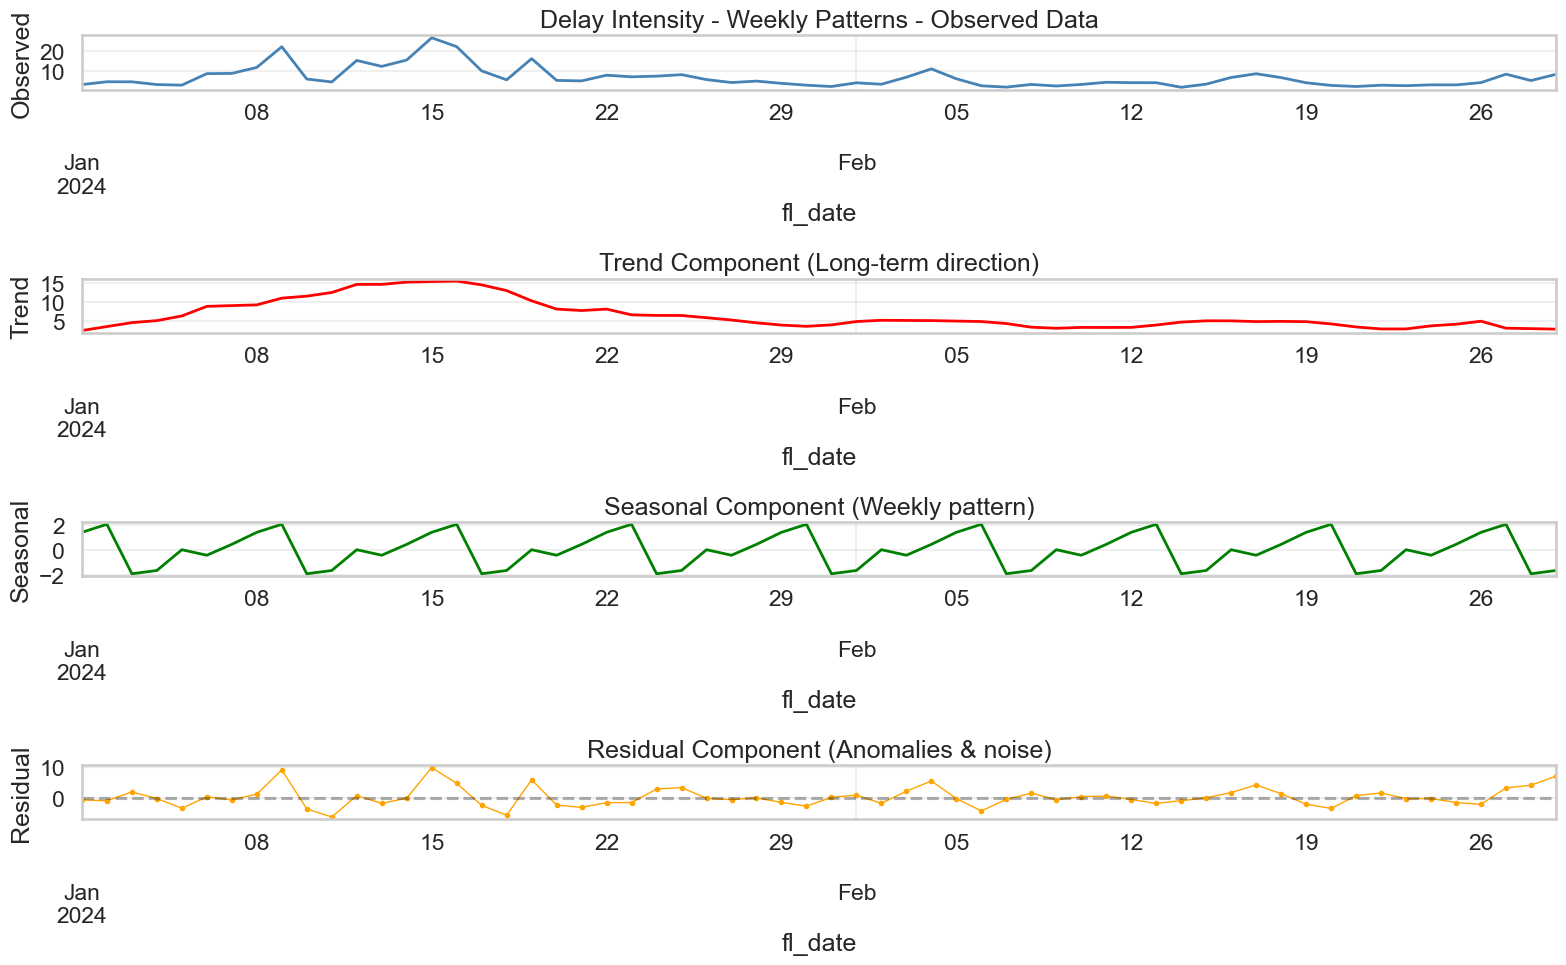


✓ Chart saved: 04_delay_intensity_decomposition.png


In [30]:

# Analyze Delay Intensity
print("\n" + "="*70)
print("SEASONAL DECOMPOSITION: DELAY INTENSITY (Weekly Period=7)")
print("="*70)

delay_decomp = seasonal_decomposition_analysis(ts_data, 'delay_intensity', period=7)

seasonal_strength_delay = 1 - (delay_decomp.resid.var() / (delay_decomp.seasonal + delay_decomp.resid).var())

print(f"Delay Intensity Insights:")
print(f"   • Seasonal Strength: {seasonal_strength_delay:.3f}")
print(f"   • Average Delay per Flight: {ts_data['delay_intensity'].mean():.2f} minutes")
print(f"   • Min Delay per Flight: {ts_data['delay_intensity'].min():.2f} minutes")
print(f"   • Max Delay per Flight: {ts_data['delay_intensity'].max():.2f} minutes")

fig4 = plot_decomposition(delay_decomp, title='Delay Intensity - Weekly Patterns')
plt.savefig(f'{OUTPUT_DIR}/04_delay_intensity_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: 04_delay_intensity_decomposition.png")

### Chart Explanation: Delay Intensity Decomposition

**What it shows:**
- **Observed**: Total average delay per flight (combined weather + late aircraft delays in minutes)
- **Trend**: Whether operational delays are improving or worsening over the analysis period
- **Seasonal**: Which days of the week are systematically more or less delayed
- **Residual**: Unexplained delay spikes - often correlate with major weather events or system disruptions

**Key Insights:**
- **Strong weekly pattern** = certain days (e.g., Fridays) are predictably more delayed than others
- **Increasing trend** = operational issues getting worse - requires investigation and intervention
- **Large residuals** = specific dates with anomalous delays - worth correlating with weather data and incident logs

## 3. Day-of-Week Pattern Analysis

This section examines how operational metrics vary systematically by day of the week.

In [31]:

def day_of_week_analysis(ts_data):
    """
    Calculate statistics grouped by day of week.
    
    Args:
        ts_data: Time series data
        
    Returns:
        DataFrame with aggregated statistics by day of week
    """
    dow_stats = ts_data.groupby('day_name').agg({
        'flight_count': ['mean', 'std', 'min', 'max'],
        'cancellation_rate': ['mean', 'std'],
        'avg_air_time': ['mean', 'std'],
        'delay_intensity': ['mean', 'std'],
        'operational_efficiency': ['mean', 'std']
    }).round(3)
    
    # Flatten column names
    dow_stats.columns = [f"{col[0]}_{col[1]}" for col in dow_stats.columns]
    
    # Reorder by actual day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_stats = dow_stats.reindex([day for day in day_order if day in dow_stats.index])
    
    return dow_stats

# Calculate day of week statistics
dow_stats = day_of_week_analysis(ts_data)

print("\n" + "="*70)
print("DAY-OF-WEEK STATISTICS")
print("="*70)
print(f"\n{dow_stats}")

# Calculate summary metrics
weekday_flights = ts_data[~ts_data['is_weekend']]['flight_count'].mean()
weekend_flights = ts_data[ts_data['is_weekend']]['flight_count'].mean()
weekday_delays = ts_data[~ts_data['is_weekend']]['delay_intensity'].mean()
weekend_delays = ts_data[ts_data['is_weekend']]['delay_intensity'].mean()

print(f"Summary Insights:")
print(f"   • Weekday Average Flights: {weekday_flights:.1f}")
print(f"   • Weekend Average Flights: {weekend_flights:.1f}")
print(f"   • Difference: {abs(weekday_flights - weekend_flights):.1f} flights ({abs(weekday_flights - weekend_flights)/min(weekday_flights, weekend_flights)*100:.1f}%)")
print(f"\n   • Weekday Average Delay: {weekday_delays:.2f} minutes")
print(f"   • Weekend Average Delay: {weekend_delays:.2f} minutes")
print(f"   • Difference: {abs(weekday_delays - weekend_delays):.2f} minutes")


DAY-OF-WEEK STATISTICS

           flight_count_mean  flight_count_std  flight_count_min  \
day_name                                                           
Monday             18451.333           544.256             17265   
Tuesday            16984.444           930.891             16134   
Wednesday          17213.333           684.126             16690   
Thursday           16689.667          5821.412              1188   
Friday             18685.250           352.618             18109   
Saturday           15934.875           585.739             15483   
Sunday             18445.625           471.828             17583   

           flight_count_max  cancellation_rate_mean  cancellation_rate_std  \
day_name                                                                     
Monday                19108                   0.030                  0.051   
Tuesday               18977                   0.034                  0.046   
Wednesday             18520                   0.01

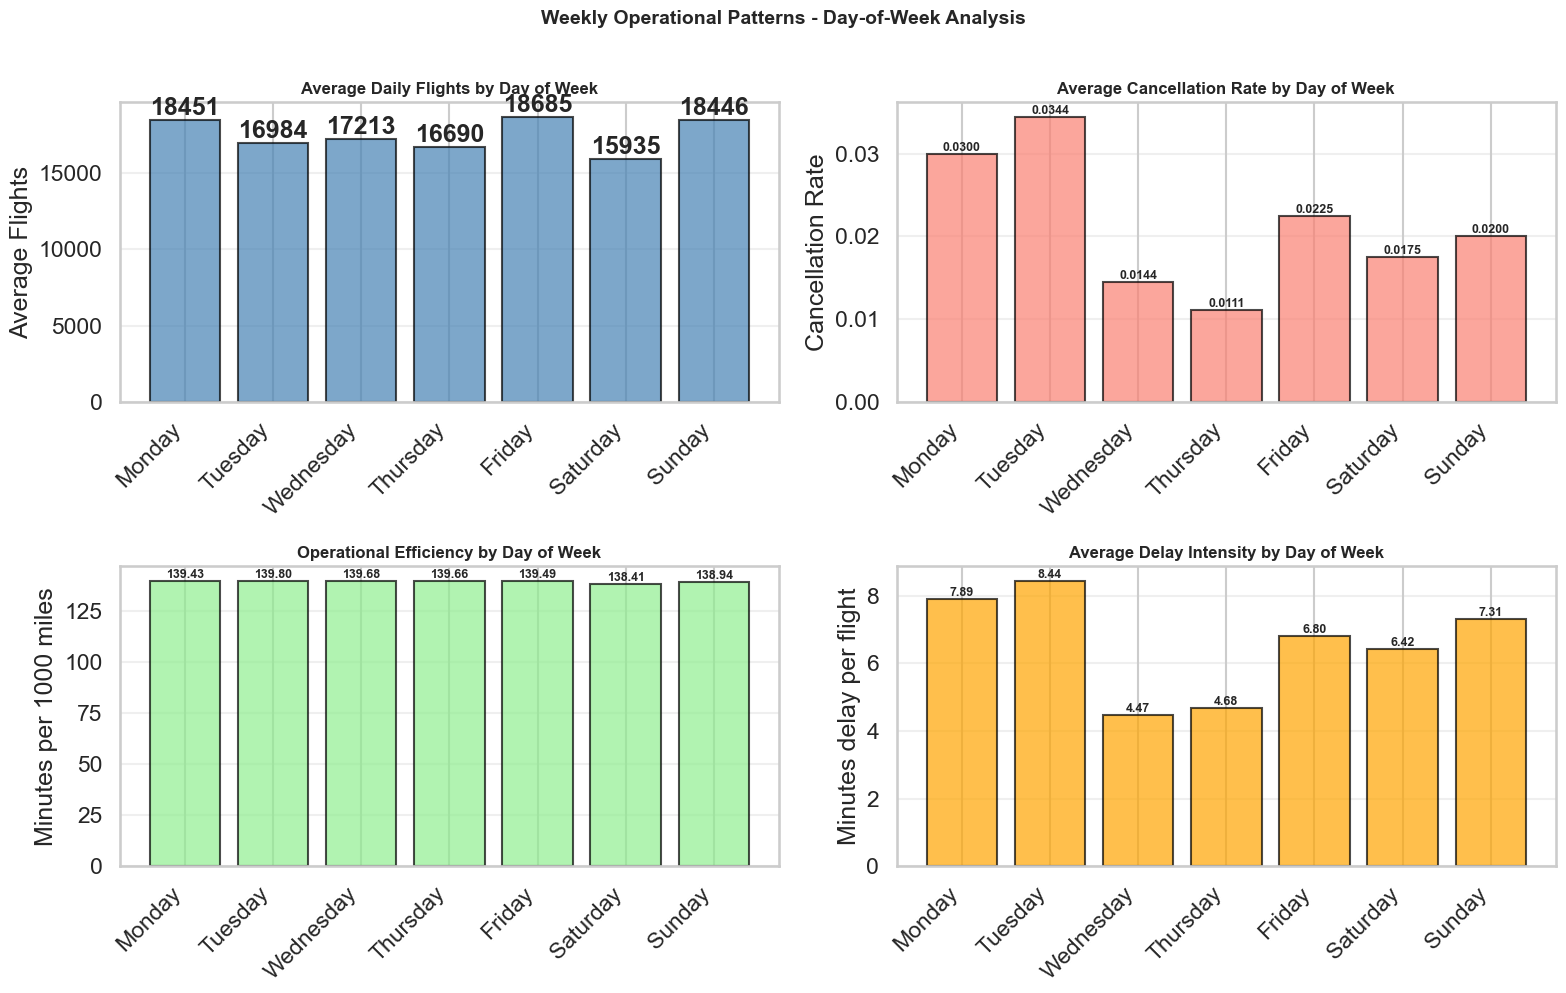


✓ Chart saved: 05_weekly_patterns_analysis.png


In [32]:

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Day order for consistent x-axis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 1. Flight count by day of week
flight_by_dow = ts_data.groupby('day_name')['flight_count'].mean().reindex(day_order)
axes[0, 0].bar(range(len(flight_by_dow)), flight_by_dow.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(day_order)))
axes[0, 0].set_xticklabels(day_order, rotation=45, ha='right')
axes[0, 0].set_title('Average Daily Flights by Day of Week', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Average Flights')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(flight_by_dow.values):
    axes[0, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Cancellation rate by day of week
cancel_by_dow = ts_data.groupby('day_name')['cancellation_rate'].mean().reindex(day_order)
axes[0, 1].bar(range(len(cancel_by_dow)), cancel_by_dow.values, color='salmon', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(day_order)))
axes[0, 1].set_xticklabels(day_order, rotation=45, ha='right')
axes[0, 1].set_title('Average Cancellation Rate by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Cancellation Rate')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(cancel_by_dow.values):
    axes[0, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Operational efficiency by day of week
eff_by_dow = ts_data.groupby('day_name')['operational_efficiency'].mean().reindex(day_order)
axes[1, 0].bar(range(len(eff_by_dow)), eff_by_dow.values, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(day_order)))
axes[1, 0].set_xticklabels(day_order, rotation=45, ha='right')
axes[1, 0].set_title('Operational Efficiency by Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Minutes per 1000 miles')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(eff_by_dow.values):
    axes[1, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Delay intensity by day of week
delay_by_dow = ts_data.groupby('day_name')['delay_intensity'].mean().reindex(day_order)
axes[1, 1].bar(range(len(delay_by_dow)), delay_by_dow.values, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(day_order)))
axes[1, 1].set_xticklabels(day_order, rotation=45, ha='right')
axes[1, 1].set_title('Average Delay Intensity by Day of Week', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Minutes delay per flight')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(delay_by_dow.values):
    axes[1, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('Weekly Operational Patterns - Day-of-Week Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_weekly_patterns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: 05_weekly_patterns_analysis.png")

### Chart Explanation: Weekly Operational Patterns (4-Panel View)

**Panel 1 - Flight Count by Day:**
- Shows which days have highest demand
- **Busiest day** = plan for highest staffing and maintenance needs
- **Quietest day** = opportunity for maintenance and crew rest
- **Pattern**: Weekdays vs weekends reveal business vs leisure travel demand

**Panel 2 - Cancellation Rate by Day:**
- Reveals operational reliability by day of week
- **High cancellation days** = systemic issues worth investigating
- **Low cancellation days** = best practices to replicate
- **Pattern**: Weekday vs weekend weather patterns often show clear differences

**Panel 3 - Operational Efficiency by Day:**
- Air time per 1000 miles (lower = more efficient)
- **Variations** might indicate different aircraft mix, routing, or congestion levels
- **Consistent across days** = stable operations; **high variability** = operational inconsistency

**Panel 4 - Delay Intensity by Day:**
- Average total delay per flight
- **Consistent delays on same days** = predictable patterns (e.g., Friday congestion)
- **Monday low delays** = possible weekend backlog clearing or lighter load

## 4. Key Findings & Summary

This section summarizes the major insights from the time series analysis.

In [35]:

def generate_summary_insights(ts_data, decomposition_results):
    """Generate key insights from the analysis."""
    
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY & KEY FINDINGS")
    print("="*70)
    
    # Trend analysis
    flight_trend = ts_data['flight_count'].diff().mean()
    trend_direction = 'INCREASING ↗' if flight_trend > 0 else 'DECREASING ↘'
    
    print(f"OVERALL FLIGHT VOLUME TREND: {trend_direction}")
    print(f"Average daily change: {flight_trend:+.2f} flights/day")
    
    # Day of week patterns
    dow_flights = ts_data.groupby('day_name')['flight_count'].mean()
    busiest_day = dow_flights.idxmax()
    quietest_day = dow_flights.idxmin()
    
    print(f"BUSIEST DAY: {busiest_day} ({dow_flights[busiest_day]:.0f} flights)")
    print(f"QUIETEST DAY: {quietest_day} ({dow_flights[quietest_day]:.0f} flights)")
    print(f"Difference: {dow_flights[busiest_day] - dow_flights[quietest_day]:.0f} flights ({(dow_flights[busiest_day] - dow_flights[quietest_day])/dow_flights[quietest_day]*100:.1f}%)")
    print("="*70)
    # Weekday vs Weekend
    weekday_avg = ts_data[~ts_data['is_weekend']]['flight_count'].mean()
    weekend_avg = ts_data[ts_data['is_weekend']]['flight_count'].mean()
    
    print(f"WEEKDAY vs WEEKEND:")
    print(f"Weekday average: {weekday_avg:.1f} flights/day")
    print(f"Weekend average: {weekend_avg:.1f} flights/day")
    print(f"Difference: {abs(weekday_avg - weekend_avg):.1f} flights ({abs(weekday_avg - weekend_avg)/min(weekday_avg, weekend_avg)*100:.1f}%)")
    print("="*70)
    # Cancellation patterns
    overall_cancel_rate = ts_data['cancellation_rate'].mean()
    dow_cancel = ts_data.groupby('day_name')['cancellation_rate'].mean()
    worst_cancel_day = dow_cancel.idxmax()
    best_cancel_day = dow_cancel.idxmin()
    print("="*70)
    print(f"CANCELLATION RELIABILITY:")
    print(f"Overall cancellation rate: {overall_cancel_rate:.4f} ({overall_cancel_rate*100:.2f}%)")
    print(f"Worst day: {worst_cancel_day} ({dow_cancel[worst_cancel_day]:.4f}, {dow_cancel[worst_cancel_day]*100:.2f}%)")
    print(f"Best day: {best_cancel_day} ({dow_cancel[best_cancel_day]:.4f}, {dow_cancel[best_cancel_day]*100:.2f}%)")
    print("="*70)
    # Delay patterns
    avg_delay = ts_data['delay_intensity'].mean()
    max_delay = ts_data['delay_intensity'].max()
    min_delay = ts_data['delay_intensity'].min()
    print("="*70)
    print(f"OPERATIONAL DELAYS:")
    print(f"Average delay per flight: {avg_delay:.2f} minutes")
    print(f"Highest single-day delay: {max_delay:.2f} minutes")
    print(f"Lowest single-day delay: {min_delay:.2f} minutes")
    
    dow_delay = ts_data.groupby('day_name')['delay_intensity'].mean()
    worst_delay_day = dow_delay.idxmax()
    best_delay_day = dow_delay.idxmin()
    print(f"Worst delay day: {worst_delay_day} ({dow_delay[worst_delay_day]:.2f} min)")
    print(f"Best delay day: {best_delay_day} ({dow_delay[best_delay_day]:.2f} min)")
    print("="*70)
    # Seasonal strength summary
    print(f"SEASONAL STRENGTH (Weekly Pattern Strength - 0 to 1):")
    print(f"Flight Count: {seasonal_strength:.3f}")
    print(f"Cancellation Rate: {seasonal_strength_cancel:.3f}")
    print(f"Air Time: {seasonal_strength_air:.3f}")
    print(f"Delay Intensity: {seasonal_strength_delay:.3f}")
    
    if max(seasonal_strength, seasonal_strength_cancel, seasonal_strength_air, seasonal_strength_delay) > 0.5:
        print(f"   → STRONG weekly patterns detected. Operations vary significantly by day of week.")
    else:
        print(f"   → WEAK weekly patterns. Operations are relatively consistent across days.")
    
    # Recommendations
    print(f"ACTIONABLE RECOMMENDATIONS:")
    
    if flight_trend > 0:
        print(f"   Flight volume is INCREASING - prepare for capacity constraints")
    else:
        print(f"   Flight volume is DECREASING - consider fleet right-sizing")
    
    if overall_cancel_rate > 0.02:
        print(f"   Cancellation rate > 2% - investigate reliability issues")
    
    if avg_delay > 15:
        print(f"   Average delay > 15 min - operational efficiency improvements needed")
    
    if abs(weekday_avg - weekend_avg) / min(weekday_avg, weekend_avg) > 0.2:
        print(f"   Large weekday/weekend difference - consider dynamic scheduling/staffing")
    
    print(f"\n{'='*70}\n")

# Generate summary
generate_summary_insights(ts_data, None)


ANALYSIS SUMMARY & KEY FINDINGS
OVERALL FLIGHT VOLUME TREND: DECREASING ↘
Average daily change: -272.49 flights/day
BUSIEST DAY: Friday (18685 flights)
QUIETEST DAY: Saturday (15935 flights)
Difference: 2750 flights (17.3%)
WEEKDAY vs WEEKEND:
Weekday average: 17580.2 flights/day
Weekend average: 17190.2 flights/day
Difference: 390.0 flights (2.3%)
CANCELLATION RELIABILITY:
Overall cancellation rate: 0.0215 (2.15%)
Worst day: Tuesday (0.0344, 3.44%)
Best day: Thursday (0.0111, 1.11%)
OPERATIONAL DELAYS:
Average delay per flight: 6.56 minutes
Highest single-day delay: 26.76 minutes
Lowest single-day delay: 1.68 minutes
Worst delay day: Tuesday (8.44 min)
Best delay day: Wednesday (4.47 min)
SEASONAL STRENGTH (Weekly Pattern Strength - 0 to 1):
Flight Count: 0.164
Cancellation Rate: 0.259
Air Time: 0.356
Delay Intensity: 0.162
   → WEAK weekly patterns. Operations are relatively consistent across days.
ACTIONABLE RECOMMENDATIONS:
   Flight volume is DECREASING - consider fleet right-siz

## 5. How to Use These Insights

### For Operations Teams:
- **Busiest vs Quietest Days**: Use to schedule staff, maintenance, and crew rest
- **Cancellation Patterns**: Target improvement efforts on unreliable days
- **Delay Analysis**: Investigate root causes of high-delay days

### For Planning & Finance:
- **Volume Trends**: Plan fleet expansion/reduction based on growth trajectory
- **Weekday/Weekend Mix**: Optimize pricing and capacity allocation
- **Seasonal Patterns**: Forecast revenue and operational costs

### For Quality & Reliability:
- **Residual Anomalies**: Investigate unusual spikes in delays or cancellations
- **Seasonal Strength**: If strong, optimize operations for patterns; if weak, investigate causes
- **Operational Efficiency**: Track trends to ensure improvements are sustained

---

## 6. Technical Appendix

### About Seasonal Decomposition
- **Additive Model**: Used when seasonal variation is roughly constant over time
- **Period = 7**: Captures weekly patterns (Monday-Sunday cycle)
- **Extrapolate Trend**: Uses frequency domain to handle edge effects

### Metrics Definitions
- **Operational Efficiency**: (Air Time / Distance) × 1000 = minutes per 1000 miles
- **Delay Intensity**: (Weather Delay + Late Aircraft Delay) / Flight Count = average delay per flight
- **Seasonal Strength**: 1 - (Residual Variance / Seasonal+Residual Variance)

### Data Quality
- Missing values in delays filled with 0 (indicates on-time)
- All metrics rounded to 2-3 decimal places for clarity
- Datetime index ensures temporal ordering

In [36]:

# Final summary and next steps
print("\n" + "="*70)
print("ANALYSIS COMPLETE ✅")
print("="*70)
print(f"\nGenerated Outputs:")
print(f"   📊 01_flight_count_decomposition.png")
print(f"   📊 02_cancellation_rate_decomposition.png")
print(f"   📊 03_air_time_decomposition.png")
print(f"   📊 04_delay_intensity_decomposition.png")
print(f"   📊 05_weekly_patterns_analysis.png")
print(f"\nOutput Directory: {OUTPUT_DIR}/")

print(f"\nNext Steps:")
print(f"   1. Download the charts from the outputs folder")
print(f"   2. Share insights with operations teams")
print(f"   3. Investigate high-variance days and anomalies")
print(f"   4. Use findings to optimize schedules and staffing")
print(f"   5. Monitor trends over time to track improvements")

print(f"\n" + "="*70 + "\n")


ANALYSIS COMPLETE ✅

Generated Outputs:
   📊 01_flight_count_decomposition.png
   📊 02_cancellation_rate_decomposition.png
   📊 03_air_time_decomposition.png
   📊 04_delay_intensity_decomposition.png
   📊 05_weekly_patterns_analysis.png

Output Directory: outputs/

Next Steps:
   1. Download the charts from the outputs folder
   2. Share insights with operations teams
   3. Investigate high-variance days and anomalies
   4. Use findings to optimize schedules and staffing
   5. Monitor trends over time to track improvements


